In [1]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter as fsf
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.ticker import FormatStrFormatter as fsf
from matplotlib.gridspec import GridSpec
from plots.mpltoolkit import (named_colors, mpl_loc,
    fancy_legend, load_mpl_presets, append_axes, markers, append_axes)
import vice
# from vice.yields.presets import JW20
import numpy as np
import math as m
import sys
sys.path.append("..")
load_mpl_presets()
print(sys.version_info)

/var/home/johnson.7419.local/VICE/vice/__init__.py:141: UserWarning: Using un-released version of VICE
  warnings.warn("Using un-released version of VICE", UserWarning)


sys.version_info(major=3, minor=10, micro=4, releaselevel='final', serial=0)


In [2]:
raw = np.genfromtxt("../mocksamples/fiducial.dat")
mock = vice.dataframe({})
mock["[fe/h]"] = raw[:, 0]
mock["[fe/h]_err"] = raw[:, 1]
mock["[o/fe]"] = raw[:, 2]
mock["[o/fe]_err"] = raw[:, 3]
mock["age"] = [10**_ for _ in raw[:, 4]]
mock["age_err"] = [a * b * m.log(10) for a, b in zip(mock["age"], raw[:, 5])]

/home/johnson.7419/tmp/ipykernel_32123/3149541280.py:59: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


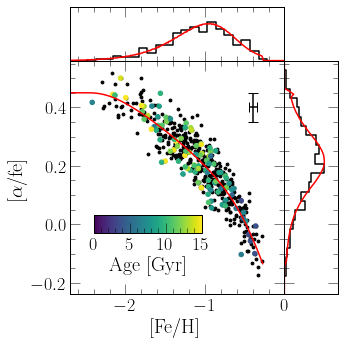

In [10]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_xlabel("[Fe/H]")
ax.set_ylabel(r"[$\alpha$/fe]")
ax.set_xlim([-2.7, 0])
ax.set_ylim([-0.24, 0.56])

kwargs = {
    "c": named_colors()["black"],
    "s": 8
}
ax.scatter(mock["[fe/h]"], mock["[o/fe]"], **kwargs)
kwargs["s"] = 20
kwargs["c"] = mock["age"]
kwargs["cmap"] = "viridis"
kwargs["vmin"] = 0
kwargs["vmax"] = 15
sc = ax.scatter(mock["[fe/h]"], mock["[o/fe]"], **kwargs)
cbar_ax = fig.add_axes([0.27, 0.32, 0.3, 0.05])
cbar = plt.colorbar(sc, cax = cbar_ax, pad = 0, orientation = "horizontal")
cbar.set_label("Age [Gyr]", labelpad = 3)
cbar.set_ticks(range(0, 16, 5))
ax.errorbar(-0.4, 0.4, xerr = 0.05, yerr = 0.05, c = named_colors()["black"])

top = fig.add_axes([0.1, 0.9, 0.8, 0.1])
right = fig.add_axes([0.9, 0.1, 0.1, 0.8])
plt.setp(top.get_xticklabels(), visible = False)
plt.setp(top.get_yticklabels(), visible = False)
plt.setp(right.get_xticklabels(), visible = False)
plt.setp(right.get_yticklabels(), visible = False)
top.set_xlim(ax.get_xlim())
top.set_ylim([0, 1.5])
top.tick_params(axis = "y", which = "both", left = False, right = False)
right.set_xlim([0, 5])
right.set_ylim(ax.get_ylim())
right.tick_params(axis = "x", which = "both", bottom = False, top = False)

kwargs = {
    "bins": 25,
    "range": ax.get_xlim(),
    "density": True
}
feh_dist, feh_bins = np.histogram(mock["[fe/h]"], **kwargs)
top.step(feh_bins[:-1], feh_dist, where = "post", c = named_colors()["black"])

kwargs["range"] = ax.get_ylim()
afe_dist, afe_bins = np.histogram(mock["[o/fe]"], **kwargs)
right.step(afe_dist, afe_bins[:-1], where = "pre", c = named_colors()["black"])

with vice.output("../mocksamples/fiducial") as true:
    kwargs = {
        "c": named_colors()["red"]
    }
    ax.plot(true.history["[fe/h]"], true.history["[o/fe]"], **kwargs)
    xvals = [(a + b) / 2 for a, b in zip(true.mdf["bin_edge_left"], true.mdf["bin_edge_right"])]
    top.plot(xvals, true.mdf["dn/d[fe/h]"], **kwargs)
    right.plot(true.mdf["dn/d[o/fe]"], xvals, **kwargs)

plt.tight_layout()
plt.subplots_adjust(right = 0.8, top = 0.8)
top.set_position([
    ax.get_position().x0,
    ax.get_position().y1,
    ax.get_position().x1 - ax.get_position().x0,
    0.15
])
right.set_position([
    ax.get_position().x1,
    ax.get_position().y0,
    0.15,
    ax.get_position().y1 - ax.get_position().y0
])
for ext in ["pdf", "jpeg"]:
    kwargs = {}
    if ext == "jpeg": kwargs["dpi"] = 200
    plt.savefig("../paper/fiducial_mock_afe_feh.%s" % (ext), **kwargs)
plt.show()

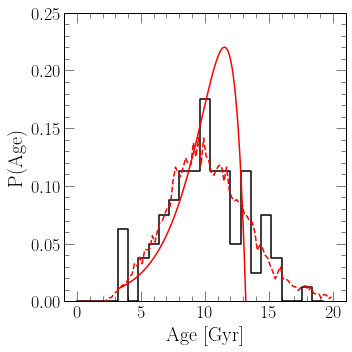

In [11]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_xlabel("Age [Gyr]")
ax.set_ylabel("P(Age)")
ax.set_xlim([-1, 21])
ax.set_ylim([0, 0.25])
# ax.set_yticks([0, 0.05, 0.1, 0.15, 0.2])

kwargs = {
    "bins": 25,
    "range": [0, 20],
    "density": True
}
age_dist, age_bins = np.histogram(mock["age"], **kwargs)
ax.step(age_bins[:-1], age_dist, where = "post", c = named_colors()["black"])

with vice.output("../mocksamples/fiducial") as true:
    diff = 13.2 - true.history["time"][-1]
    xvals = [_ + diff for _ in true.history["lookback"]]
    norm = sum(true.history["sfr"]) * (true.history["time"][1] - true.history["time"][0])
    yvals = [_ / norm for _ in true.history["sfr"]]
    ax.plot(xvals, yvals, c = named_colors()["red"])
    
    totsfr = sum(true.history["sfr"])
    sfrfrac = [_ / totsfr for _ in true.history["sfr"]]
    indeces = np.random.choice(list(range(len(sfrfrac))), p = sfrfrac, size = int(1e4))
    resampled = [diff + true.history["lookback"][indeces[_]] for _ in range(len(indeces))]
    resampled = [10**(m.log10(_) + np.random.normal(scale = 0.1)) for _ in resampled]
    dist, bins = np.histogram(resampled, bins = 100, range = [0, 20], density = True)
    xvals = [(a + b) / 2 for a, b in zip(bins[1:], bins[:-1])]
    ax.plot(xvals, dist, c = named_colors()["red"], linestyle = '--')

plt.tight_layout()
for ext in ["pdf", "jpeg"]:
    kwargs = {}
    if ext == "jpeg": kwargs["dpi"] = 200
    plt.savefig("../paper/fiducial_mock_agedist.%s" % (ext), **kwargs)
plt.show()

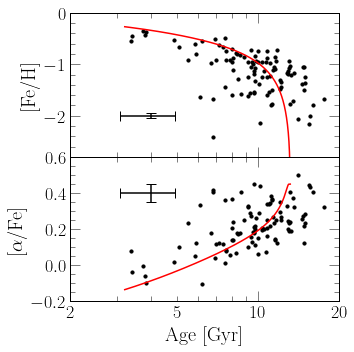

In [14]:
fig = plt.figure()
top = fig.add_subplot(211)
bottom = fig.add_subplot(212)
for ax in [top, bottom]:
    ax.set_xscale("log")
    ax.set_xlim([2, 20])
plt.setp(top.get_xticklabels(which = "both"), visible = False)
bottom.xaxis.set_major_formatter(fsf("%g"))
bottom.xaxis.set_minor_formatter(fsf("%g"))
top.set_ylim([-2.8, 0])
bottom.set_ylim([-0.2, 0.6])
bottom.set_xlabel("Age [Gyr]")
bottom.set_ylabel(r"[$\alpha$/Fe]")
top.set_ylabel("[Fe/H]")

kwargs = {
    "c": named_colors()["black"],
    "s": 10
#     "xerr": mock["age_err"],
#     "linestyle": "None"
}
top.scatter(mock["age"], mock["[fe/h]"], **kwargs)
bottom.scatter(mock["age"], mock["[o/fe]"], **kwargs)
# top.errorbar(mock["age"], mock["[fe/h]"], yerr = mock["[fe/h]_err"], **kwargs)
# bottom.errorbar(mock["age"], mock["[o/fe]"], yerr = mock["[o/fe]_err"], **kwargs)

bottom.set_xticks(range(2, 10), [str(_) if _ == 2 or _ == 5 else "" for _ in range(2, 10)], minor = True)
bottom.set_xticks([10, 20], minor = False)

ageval = 4
age_err = [[ageval - 10**(m.log10(ageval - 0.1 * ageval * m.log(10)))],
    [10**(m.log10(ageval + 0.1 * ageval * m.log(10))) - ageval]]
bottom.errorbar(ageval, 0.4, xerr = age_err, yerr = 0.05, c = named_colors()["black"])
top.errorbar(ageval, -2, xerr = age_err, yerr = 0.05, c = named_colors()["black"])

with vice.output("../mocksamples/fiducial") as true:
    diff = 13.2 - true.history["time"][-1]
    xvals = [_ + diff for _ in true.history["lookback"]]
    top.plot(xvals, true.history["[fe/h]"], c = named_colors()["red"])
    bottom.plot(xvals, true.history["[o/fe]"], c = named_colors()["red"])

plt.tight_layout()
plt.subplots_adjust(hspace = 0, left = 0.2)
for ext in ["pdf", "jpeg"]:
    kwargs = {}
    if ext == "jpeg": kwargs["dpi"] = 200
    plt.savefig("../paper/fiducial_mock_amr.%s" % (ext), **kwargs)
plt.show()